In [ ]:
from mpmath.tests.runtests import coverage
%load_ext autoreload
%autoreload 2

from typing import List, Optional
from omegaconf import OmegaConf
import os
import time
import json
import wandb
import logging
import argparse

import torch
import numpy as np
from datasets.driving_dataset import DrivingDataset
from datasets.my_dataset import MyDataset
from utils.misc import import_str
from models.trainers import BasicTrainer
from models.video_utils import (
    render_images,
    save_videos,
    render_novel_views
)


In [ ]:
cfg = OmegaConf.load(os.path.join("/mnt/e/Output/cam5/149", "config.yaml"))
%cd /home/a/drivestudio

dataset = MyDataset(cfg.data)

In [ ]:
source = dataset.lidar_source
points = source.origins + source.directions * source.ranges
grounds = source.grounds
flow_class = source.flow_classes
points.shape, grounds.shape, flow_class.shape

In [ ]:
import matplotlib.pyplot as plt

def plot_lidar_points(lidar_points, ground_mask=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(lidar_points[:, 0][~ground_mask], lidar_points[:, 1][~ground_mask], c='b', s=1)  # 2D scatter plot
    plt.title('2D Lidar Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

plot_lidar_points(points.numpy(), grounds.numpy())  # Convert to numpy array for plotting


In [ ]:
import torch.nn.functional as F

def create_voxel_grid_2d(lidar_points, voxel_size=1):
    z = lidar_points[:, 2]
    lidar_points = lidar_points[(-1 <= z) & (z <= 3)]
    x_min, x_max = lidar_points[:, 0].min(), lidar_points[:, 0].max()
    y_min, y_max = lidar_points[:, 1].min(), lidar_points[:, 1].max()
    
    grid_size_x = int((x_max - x_min) / voxel_size) + 1
    grid_size_y = int((y_max - y_min) / voxel_size) + 1
    
    voxel_grid = torch.zeros((grid_size_x, grid_size_y), dtype=torch.int32)
    
    # 计算每个点的体素索引
    voxel_indices_x = ((lidar_points[:, 0] - x_min) / voxel_size).long()
    voxel_indices_y = ((lidar_points[:, 1] - y_min) / voxel_size).long()
    
    # 将二维索引展平成一维索引
    flat_indices = voxel_indices_x * grid_size_y + voxel_indices_y
    
    # 使用 torch.bincount 统计每个体素的点数量
    counts = torch.bincount(flat_indices, minlength=grid_size_x * grid_size_y)
    
    # 将一维结果重塑为二维网格
    voxel_grid = counts.view(grid_size_x, grid_size_y)
    
    return voxel_grid

p = points[~grounds]
c = flow_class[~grounds]

# 生成2D体素网格
voxel_grid_2d = create_voxel_grid_2d(p[c<=0])


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(voxel_grid_2d.numpy() > 3, cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()


In [88]:

cameras = dataset.pixel_source.camera_data
camera_0 = cameras[1]

poses = camera_0.cam_to_worlds
intrinsic = camera_0.intrinsics[0]
fov = 2 * torch.atan2(intrinsic[0, 2], intrinsic[0, 0])  # 计算视场角 (FOV)

import math

pose = poses[1]     # 4x4
cx = pose[0, 3]
cy = pose[1, 3]
angle = math.atan2(pose[1, 0], pose[0, 0])
cameras

{0: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7f943ccbd940>,
 1: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7f943cd105b0>,
 2: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7f943cc40730>,
 3: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7f943cc409d0>,
 4: <datasets.waymo.waymo_sourceloader.WaymoCameraData at 0x7f942abedaf0>}

In [113]:
from utils.mytools import Camera, Grid2d, CameraSet
grid = Grid2d(points, grounds, flow_class, cameras)

grid.expand_area()
len(grid.area)

5058

In [114]:
grid.get_area_coverage(grid.area)

{(7, 149, 27): {'coord': (tensor(1.9580), tensor(-0.0289)),
  'fov': tensor(0.8696),
  'coverage': 0.83},
 (8, 149, 26): {'coord': (tensor(2.3888), tensor(-0.0410)),
  'fov': tensor(0.8696),
  'coverage': 0.6787386208772659},
 (9, 149, 26): {'coord': (tensor(2.8315), tensor(-0.0551)),
  'fov': tensor(0.8696),
  'coverage': 0.6999931699037552},
 (10, 149, 26): {'coord': (tensor(3.2890), tensor(-0.0715)),
  'fov': tensor(0.8696),
  'coverage': 0.7498035073280335},
 (11, 149, 26): {'coord': (tensor(3.7602), tensor(-0.0878)),
  'fov': tensor(0.8696),
  'coverage': 0.859956470131874},
 (12, 149, 26): {'coord': (tensor(4.2478), tensor(-0.1005)),
  'fov': tensor(0.8696),
  'coverage': 0.9891651880741119},
 (13, 149, 26): {'coord': (tensor(4.7531), tensor(-0.1167)),
  'fov': tensor(0.8696),
  'coverage': 0.8891107261180877},
 (14, 149, 26): {'coord': (tensor(5.2711), tensor(-0.1363)),
  'fov': tensor(0.8696),
  'coverage': 0.859525785446167},
 (15, 149, 26): {'coord': (tensor(5.7974), tensor(-

In [ ]:
map = grid.get_hot_map()

map.shape, grid.voxel_grid_2d.shape

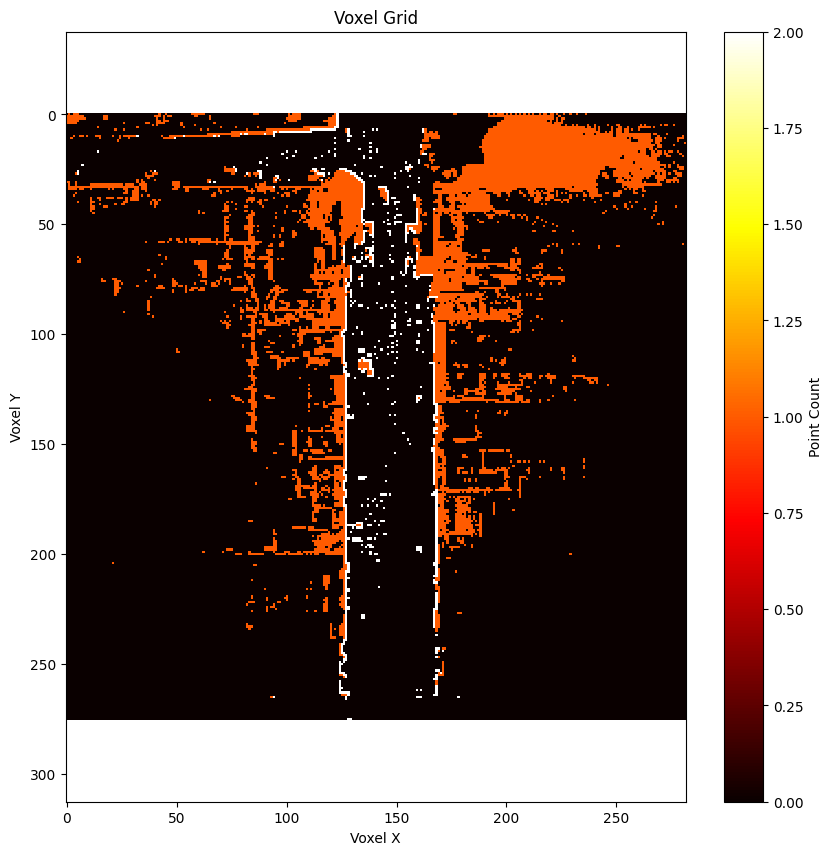

In [78]:
plt.figure(figsize=(10, 10))
plt.imshow(map.numpy(), cmap='hot', interpolation='nearest')
plt.title('Voxel Grid')
plt.xlabel('Voxel X')
plt.ylabel('Voxel Y')
plt.colorbar(label='Point Count')
plt.axis('equal')
plt.show()

In [87]:
coverages = []
for cam in cameras.values():
    print(cam)
    coverages.append(grid.get_camera_set_coverage(CameraSet(cam.cam_to_worlds, cam.intrinsics)))
print(coverages)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1

In [85]:
camera = Camera(pose, intrinsic)
grid.get_camera_coverage(camera)

1.0